In [ ]:
from google.colab import files
files.upload()

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [3]:
!unzip data.zip

Archive:  data.zip
  inflating: feature.csv             
  inflating: feature2.csv            
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               


In [25]:
data_dir = Path('.')
sub_dir = Path('./sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'

target_col = 'Survived'
seed = 42

In [26]:
feature_file = data_dir / 'feature2.csv'
feat = pd.read_csv(feature_file, index_col=0)
feat.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Companion,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,2.1102,S,1.0,0,0,1
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.2806,C,1.0,1,0,0
3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.1889,S,0.0,0,0,1
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.9908,S,1.0,0,0,1
5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.2028,S,0.0,0,0,1


In [27]:
feat.drop(['Name','Ticket', 'Embarked'], axis=1, inplace=True) # Name and Ticket requires preprocessing

In [28]:
feat.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Companion,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,
1,0.0,3,1,22.0,1,0,2.1102,1.0,0,0,1
2,1.0,1,0,38.0,1,0,4.2806,1.0,1,0,0
3,1.0,3,0,26.0,0,0,2.1889,0.0,0,0,1
4,1.0,1,0,35.0,1,0,3.9908,1.0,0,0,1
5,0.0,3,1,35.0,0,0,2.2028,0.0,0,0,1


In [29]:
train_set_size = 891
y = feat[target_col].values[:train_set_size]
feat.drop(target_col, axis=1, inplace=True)
trn = feat.iloc[:train_set_size]
tst = feat.iloc[train_set_size:]
feature_name = feat.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(891,) (891, 10) (418, 10)


In [30]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(712, 10) (179, 10) (712,) (179,)


### Random Forest

In [31]:
algo_name = 'rf'
model_name = f'{algo_name}_{feature_name}'
sub_file = sub_dir / f'{model_name}.csv' 
print(sub_file)

sub/rf_['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Companion', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS'].csv


In [32]:
clf = RandomForestClassifier(n_estimators=100,
                             min_samples_leaf=10,
                             max_features='auto',
                             max_samples=.5,
                             random_state=seed,
                             n_jobs=-1)
clf.fit(X_trn, y_trn)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

In [33]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

81.5642%


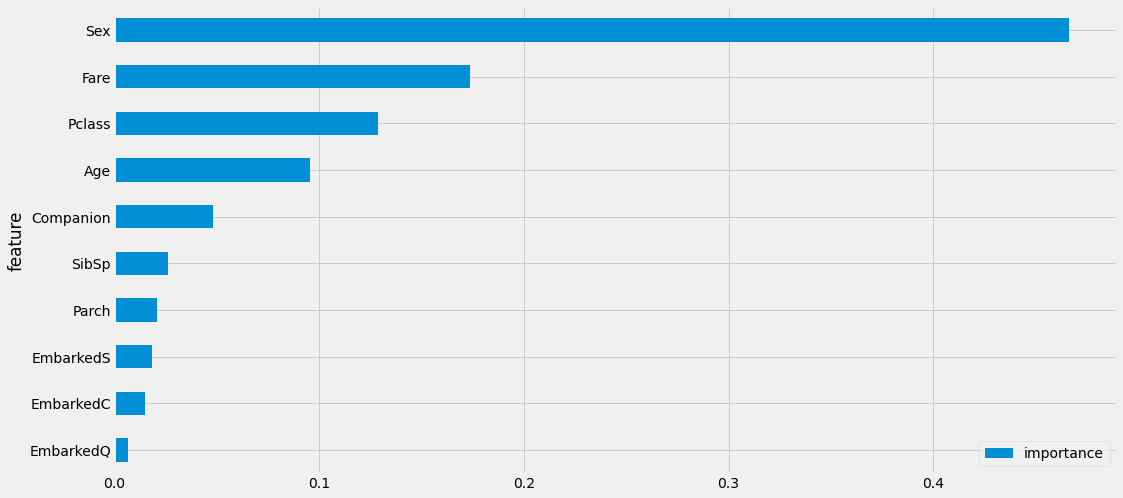

In [34]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Light GBM

In [40]:
algo_name = 'lgbm'
model_name = f'{algo_name}_{feature_name}' # {feature_name} 사용하면 파일명이 지나치게 길어져 제출시 에러 발생
sub_file = sub_dir / f'{model_name}.csv'
print(sub_file)

sub/lgb_['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Companion', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS'].csv


In [42]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(objective='binary',
                         n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)
clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='binary',
        early_stopping_rounds=10)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

[1]	valid_0's binary_logloss: 0.641904
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.60704
[3]	valid_0's binary_logloss: 0.578104
[4]	valid_0's binary_logloss: 0.553382
[5]	valid_0's binary_logloss: 0.531899
[6]	valid_0's binary_logloss: 0.515221
[7]	valid_0's binary_logloss: 0.508985
[8]	valid_0's binary_logloss: 0.496375
[9]	valid_0's binary_logloss: 0.489475
[10]	valid_0's binary_logloss: 0.479458
[11]	valid_0's binary_logloss: 0.466628
[12]	valid_0's binary_logloss: 0.458098
[13]	valid_0's binary_logloss: 0.451191
[14]	valid_0's binary_logloss: 0.443709
[15]	valid_0's binary_logloss: 0.441654
[16]	valid_0's binary_logloss: 0.439362
[17]	valid_0's binary_logloss: 0.431888
[18]	valid_0's binary_logloss: 0.433514
[19]	valid_0's binary_logloss: 0.431833
[20]	valid_0's binary_logloss: 0.426858
[21]	valid_0's binary_logloss: 0.42555
[22]	valid_0's binary_logloss: 0.425826
[23]	valid_0's binary_logloss: 0.423177
[24]	valid_0's binary_logloss

In [43]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

82.1229%


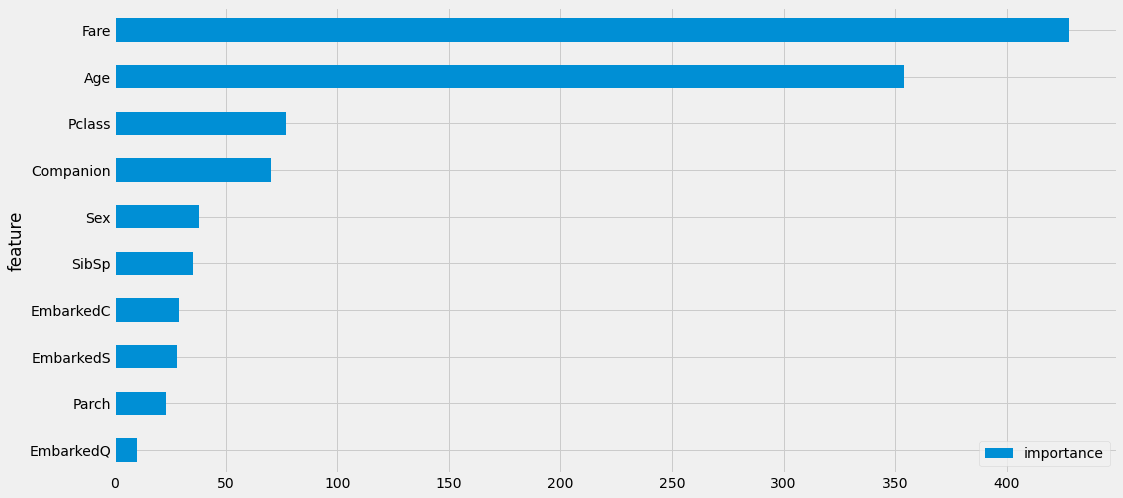

In [44]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

### Prepare for Submission

In [45]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(418, 1)


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [46]:
sub[target_col] = p_tst
sub.head()

,Survived
PassengerId,
892,0.0
893,0.0
894,0.0
895,0.0
896,0.0


In [47]:
sub[target_col].value_counts()

0.0    274
1.0    144
Name: Survived, dtype: int64

In [48]:
sub.to_csv(sub_file)

In [49]:
files.download(sub_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>